In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import math
import os
from collections import defaultdict
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

import trtools.utils.utils
from mutation_pattern_utils import *

In [6]:
#### Load mutation datasets ####
DATADIR = '../../BXD-STR-Mutator-Manuscript/outs'

auto = pd.read_csv(os.path.join(DATADIR, 'denovo_strs_filtered.csv'))
X = pd.read_csv(os.path.join(DATADIR, 'denovo_ri_gts_homX.tsv'), sep='\t')
Y = pd.read_csv(os.path.join(DATADIR, 'denovo_ri_gts_homY.tsv'), sep='\t')

# Filter BXD194 from X/Y since we filtered from autosomes
X = X[X["strain"]!="BXD194"]
Y = Y[Y["strain"]!="BXD194"]

#### Load other metadata ###
motif_info = pd.read_csv(os.path.join(DATADIR, 'motif_info.csv'))
chr13_gt = pd.read_csv(os.path.join(DATADIR, 'fou_gt_at_peak_chr13.tsv'), sep='\t')

In [30]:
def create_master_df(df, motif_df, chr13_gt, name):
    # Add metadata
    num_mut = df.groupby(["chr", "pos"]).size().to_frame('num_mut')
    df_info = pd.merge(df, num_mut, on=['chr', 'pos'])
    df_info = pd.merge(df_info, motif_df[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])
    df_info = pd.merge(df_info, chr13_gt[['strain', 'fou_gt']], on=['strain'])
    df_info.rename(columns = {'fou_gt_y':'fou_gt_chr13'}, inplace = True)

    # Add locus-level mutation summary stats
    summary_ops = {
        "expan_perc": expan_perc,
        "num_B": num_B,
        "num_D": num_D,
        "num_expan": num_expan,
        "num_contr": num_contr,
    }
    grouped_mut = df_info.groupby(["chr", "pos"])
    for key, val in summary_ops.items():
        df = grouped_mut.apply(val).to_frame(key)
        df_info = pd.merge(df_info, df, on=['chr','pos'])
    
    # Get expan/contr info by B/D
    expan_dict = defaultdict(lambda: [0,0,0,0])
    for index, row in df_info.iterrows():
        pos = f"{row['chr']}_{row['pos']}"
        if row['fou_gt_chr13'] == 'B':
            if row['expand_type'] == 'expan':
                expan_dict[pos][0] += 1
            else:
                expan_dict[pos][1] += 1
        else:
            if row['expand_type'] == 'expan':
                expan_dict[pos][2] += 1
            else:
                expan_dict[pos][3] += 1

    # Print summary information
    print("#### Summary - %s ######"%name)
    print("Number of mutations (before filtering): %s"%df_info.shape[0])
    print("Number of unique loci (before filtering): %s"%df_info[["chr","pos"]].drop_duplicates().shape[0])

    # Remove mutations occurring >10 times
    df_info = df_info[df_info["num_mut"]<=10]
    print("Number of mutations (after filtering): %s"%df_info.shape[0])
    print("Number of unique loci (after filtering): %s"%df_info[["chr","pos"]].drop_duplicates().shape[0])
    
    # Only keep columns we want and collapse by locus
    keepcols = ["chr","pos","end","motif","motif_len","num_mut"] + list(summary_ops.keys())
    df_info = df_info[keepcols].drop_duplicates()

    # Add expan/contr info to the data frame
    df_info['expan_B'] = 0
    df_info['contr_B'] = 0
    df_info['expan_D'] = 0
    df_info['contr_D'] = 0

    for index, row in df_info.iterrows():
        pos = f"{row['chr']}_{row['pos']}"
        df_info.at[index, 'expan_B'] = expan_dict[pos][0]
        df_info.at[index, 'contr_B'] = expan_dict[pos][1]
        df_info.at[index, 'expan_D'] = expan_dict[pos][2]
        df_info.at[index, 'contr_D'] = expan_dict[pos][3]
        
    return df_info

def calc_expan_propen(df):
    num_expan_B = 0
    num_mut_B = 0
    num_expan_D = 0
    num_mut_D = 0
    for index, row in df.iterrows():
        num_expan_B += row['expan_B']
        num_mut_B += row['num_B']
        num_expan_D += row['expan_D']
        num_mut_D += row['num_D']
        
    return num_expan_B/num_mut_B, num_mut_B, num_expan_D/num_mut_D, num_mut_D

X_info = create_master_df(X, motif_info, chr13_gt, "X")
Y_info = create_master_df(Y, motif_info, chr13_gt, "Y")
auto_info = create_master_df(auto, motif_info, chr13_gt, "auto")

#### Summary - X ######
Number of mutations (before filtering): 1042
Number of unique loci (before filtering): 593
Number of mutations (after filtering): 905
Number of unique loci (after filtering): 585
#### Summary - Y ######
Number of mutations (before filtering): 186
Number of unique loci (before filtering): 73
Number of mutations (after filtering): 116
Number of unique loci (after filtering): 70
#### Summary - auto ######
Number of mutations (before filtering): 52812
Number of unique loci (before filtering): 18119
Number of mutations (after filtering): 34526
Number of unique loci (after filtering): 17249


# Supplementary Figure 11 (Sex chroms)

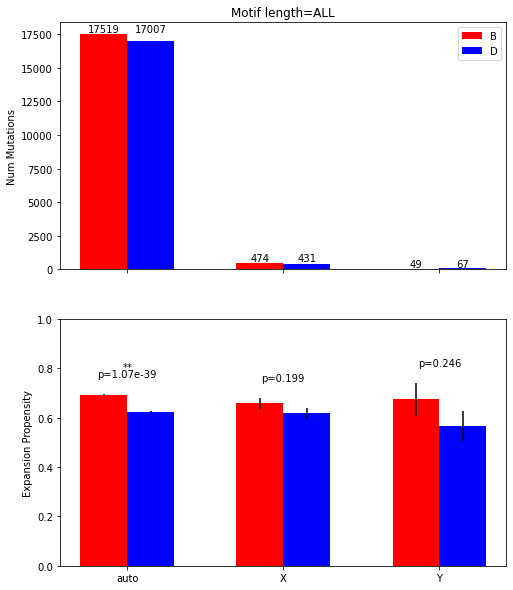

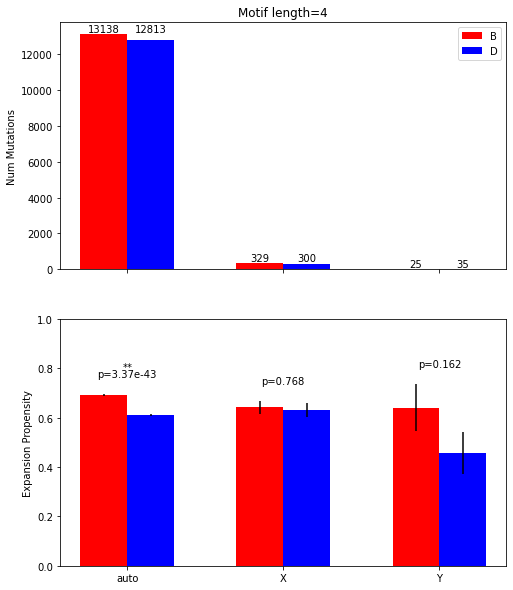

In [27]:
labels = ['auto', 'X', 'Y']

for motif_len in ["ALL", 4]:
    if motif_len == "ALL":
        dAuto = auto_info
        dX = X_info
        dY = Y_info
    else:
        dAuto = auto_info[auto_info['motif_len']==4]
        dX = X_info[X_info['motif_len']==4]
        dY = Y_info[Y_info['motif_len']==4]
            
    experc_auto_B, num_mut_auto_B, experc_auto_D, num_mut_auto_D = calc_expan_propen(dAuto)
    experc_X_B, num_mut_X_B, experc_X_D, num_mut_X_D = calc_expan_propen(dX)
    experc_Y_B, num_mut_Y_B, experc_Y_D, num_mut_Y_D = calc_expan_propen(dY)
   
    experc_B_all = [experc_auto_B, experc_X_B, experc_Y_B]
    experc_D_all = [experc_auto_D, experc_X_D, experc_Y_D]
    nummut_B_all = [num_mut_auto_B, num_mut_X_B, num_mut_Y_B]
    nummut_D_all = [num_mut_auto_D, num_mut_X_D, num_mut_Y_D]
    se_B = []
    se_D = []
    ztest_exp = []
    for i in range(len(labels)):
        se_B.append(math.sqrt(experc_B_all[i]*(1-experc_B_all[i])/nummut_B_all[i]))
        se_D.append(math.sqrt(experc_D_all[i]*(1-experc_D_all[i])/nummut_D_all[i]))
        ztest_exp.append(proportions_ztest([nummut_B_all[i]*experc_B_all[i], nummut_D_all[i]*experc_D_all[i]], [nummut_B_all[i], nummut_D_all[i]]))
        
    fig, ax = plt.subplots(2, figsize=(8, 10))
    ax[0].bar(range(len(labels)), nummut_B_all, color="red", width=0.3, label='B')
    ax[0].bar([item+0.3 for item in range(len(labels))], nummut_D_all, color="blue", width=0.3, label='D')
    ax[0].set_xticks([x+0.15 for x in range(len(labels))])
    ax[0].set(xticklabels=[])
    ax[0].set_ylabel("Num Mutations");
    ax[0].title.set_text('Motif length=%s'%motif_len)
    ax[0].legend()
    
    ### Annotate mutation numbers
    rects = ax[0].patches
    for rect, nummut_B, nummut_D in \
        zip(rects, nummut_B_all, nummut_D_all):
        height = rect.get_height()
        ax[0].text(rect.get_x() + rect.get_width()/2, height, nummut_B, ha="center", va="bottom", fontsize=10)
        ax[0].text(rect.get_x() + rect.get_width() + rect.get_width()/2, height, nummut_D, ha="center", va="bottom", fontsize=10)

    ax[1].bar(range(len(labels)), experc_B_all, color="red", width=0.3, label='B', yerr=se_B)
    ax[1].bar([item+0.3 for item in range(len(labels))], experc_D_all, color="blue", width=0.3, label='D', yerr=se_D)
    ax[1].set_ylim([0, 1])

    ### Annotate p-values
    rects = ax[1].patches
    pvals_annot = []
    pvals = [x[1] for x in ztest_exp]
    pvals_bonf = [x*len(pvals) for x in pvals]
    for i in range(len(pvals)):
        if pvals_bonf[i] < 0.05:
            pvals_annot.append('**')
        elif pvals[i] < 0.05:
            pvals_annot.append('*')
        else:
            pvals_annot.append('')
        
    pvals = [x[1] for x in ztest_exp]
    pvals[0] = f"{pvals[0]:.2e}"
    pvals[1] = round(pvals[1], 3)
    pvals[2] = round(pvals[2], 3)

    for rect, pval, annot_star, se_B_h in \
        zip(rects, pvals, pvals_annot, se_B):
        height = rect.get_height()
        ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.06), "p=%s"%pval, ha="center", va="bottom", fontsize=10)
        ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.09), annot_star , ha="center", va="bottom", fontsize=10)
    ax[1].set_xticks([x+0.15 for x in range(len(labels))])
    ax[1].set_xticklabels(labels);
    ax[1].set_ylabel("Expansion Propensity");
    fig.savefig("../pdfs/SuppFig11_ParentOfOrigin_%s.pdf"%motif_len)
